<a href="https://colab.research.google.com/github/LuizFelipe2812/Mestrado_FACOM/blob/main/Implementa%C3%A7%C3%A3o_CNN_Luiz_Felipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelos ResNet - Teste

In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.13.0


In [2]:
BATCH_SIZE = 32
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]

  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]

    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [4]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 10s 0us/step


In [5]:
# display_images(training_images, training_labels, training_labels, "Training Data" )

In [6]:
# display_images(validation_images, validation_labels, validation_labels, "Training Data" )

In [7]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims


train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

In [8]:
# Realizar o treinamento sem imagenet e com imagenet (Comparativo)
# Realizar teste com aumento de dados e sem aumento de dados


'''
A extração de características é realizada pela ResNet50 pré-treinada em pesos da imagenet.
O tamanho de entrada é 224 x 224.
'''

def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Define as camadas densas finais e a camada softmax subsequente para classificação.
'''

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Como o tamanho da imagem de entrada é (32 x 32), primeiro aumente a resolução da imagem
pelo fator de (7x7) para transformá-la em (224 x 224)
Conecte as camadas de extração de características e o "classificador" para construir o modelo.
'''

def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define o modelo
Usa o gradiente estocástico descente como otimizador.
Usa Sparse Categorical CrossEntropy como função de perda.
'''

def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)

  model.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])

  return model


model = define_compile_model()

model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                              

In [9]:
EPOCHS = 1
history = model.fit(train_X, training_labels,
                    epochs=EPOCHS,
                    validation_data = (valid_X, validation_labels),
                    batch_size=64)

782/782 [==============================] - 38248s 49s/step - loss: 0.4014 - accuracy: 0.8703 - val_loss: 0.2128 - val_accuracy: 0.9282


In [10]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 1980s 13s/step - loss: 0.2128 - accuracy: 0.9282


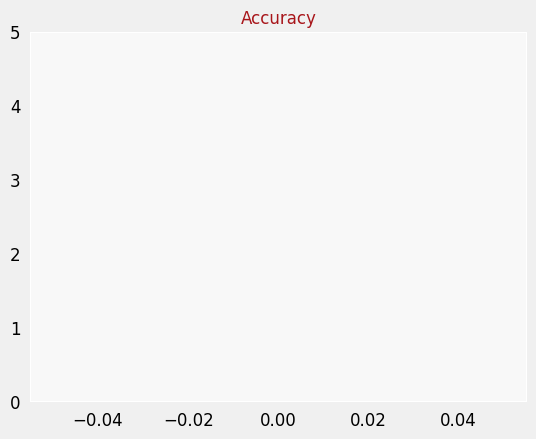

In [11]:
plot_metrics("loss", "Loss")
plot_metrics("accuracy", "Accuracy")